In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt

from time import perf_counter as clock

from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/Documents/GitHub/Master-Degree


In [2]:
#Reading and defining data of simulation
#All values are stored in the original jam_axi_rms_example.py and in the text files present in this folder
#To know: mge.txt; other_parameters.txt; vrm.txt


surf_lum, sigma_lum, qobs_lum = np.loadtxt("mge.txt", unpack=True)         #Reading data of MGE
inc_dat      = 60.          #galaxy inclination (only for dynamical model) [deg]       
mbh_dat      = 1e8          #black hole mass   [M_sun]
ML_dat       = 1.2          #mass to light ratio [M_sun/L_sun]
distance_dat = 16.5         #distance to source galaxy (for redshift) [Mpc]
qSMBH        = 1.           #Assuming a circular gaussian for bh [ad]
sigma_bh     = 0.01         #Assuming sigma for bh [arcsec]

In [3]:
#Lens parameters

z = z_at_value(cosmo.angular_diameter_distance, distance_dat * u.Mpc, zmax=1.0) #Convert distance to redshifth 
z_lens = z                                    #Lens redshift
z_source = 2.1                                #Source redshift

## Reading data

In [4]:
dataset_type = "Autolens_tests/autolens_workspace/Test_MGE_Class/"
dataset_name = "Data_new"
dataset_path = f"{workspace_path}/{dataset_type}/{dataset_name}"

pixel_scales = 0.1

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image_test.fits",
    noise_map_path=f"{dataset_path}/noise_test.fits",
    psf_path=f"{dataset_path}/psf_test.fits",
    pixel_scales=pixel_scales,
)

#Load mask

mask_custom = al.Mask.from_fits(
    file_path=f"{dataset_path}/mask.fits", hdu=0, pixel_scales=pixel_scales
)
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask_custom, inversion_uses_border=True)

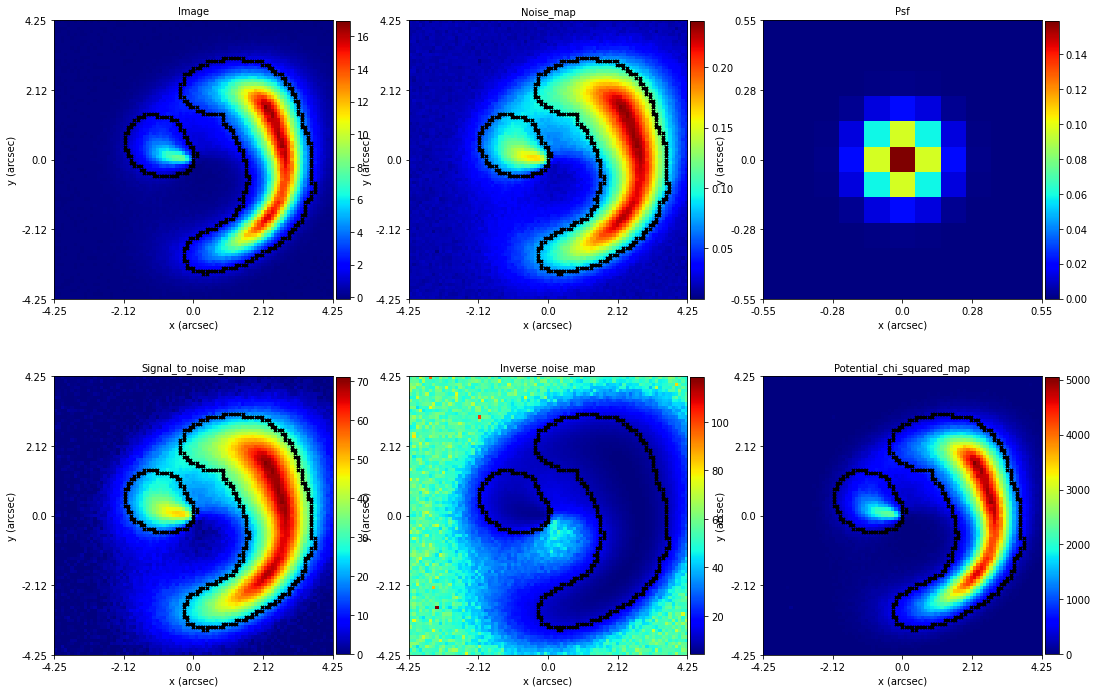

In [5]:
#Plot

aplt.Imaging.subplot_imaging(
    imaging=imaging, mask=mask_custom, include=aplt.Include(border=False),
)

## Starting model

In [7]:
#MGE mass profile

#Initializing
mass_profile = al.mp.MGE(gamma=3)
""" 
    We are assuming gamma=3 because in the last simulation there was an error in this 
    parameters during the deflection. There, we multiply the deflection angle by (1 + gamma). 
    But, the correct factor is 0.5 * (1 + gamma). So, to compare the actual implementation with 
    the previous one it is necessary to compensate this erro.
"""

#Components
mass_profile.MGE_comps(z_l=z_lens, z_s=z_source, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ML_dat,
                       mbh=mbh_dat, sigma_mbh=sigma_bh, qobs_mbh=qSMBH)

#Grid
mass_profile.MGE_Grid_parameters(masked_imaging.grid)

In [8]:
#Lens galaxy

shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=142) #external shear

lens_galaxy = al.Galaxy(
    redshift=z_lens,
    mass=mass_profile,
    shear=al.mp.ExternalShear(elliptical_comps=shear_comp)
)

In [20]:
#Now we set the tracer to the source galaxy
start = clock()

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=z_source)])
source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

print("Computation time:", (clock() - start))

Computation time: 2.462708969000232


We'll use the rectangular _Pixelization_ and _Mapper_ to perform the reconstruction.

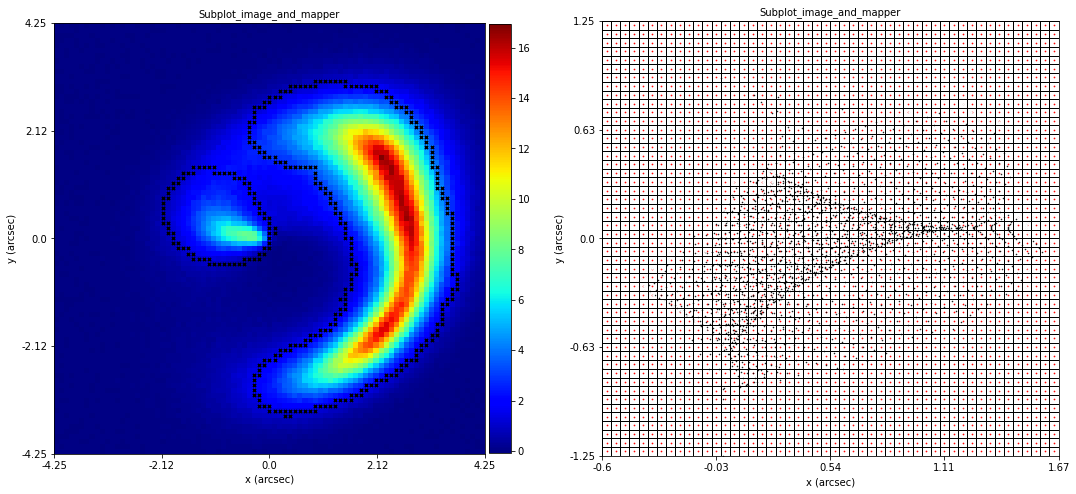

In [21]:
rectangular = al.pix.Rectangular(shape=(50, 50))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

And now, finally, we're going to use our _Mapper_ to invert the image using an _Inversion_.

In [22]:
inversion = al.Inversion(
    masked_dataset=masked_imaging,
    mapper=mapper,
    regularization=al.reg.Constant(coefficient=3.5),
)

Our _Inversion_ has a reconstructed image and _Pixeilzation_, whcih we can plot using an _Inversion_ plotter

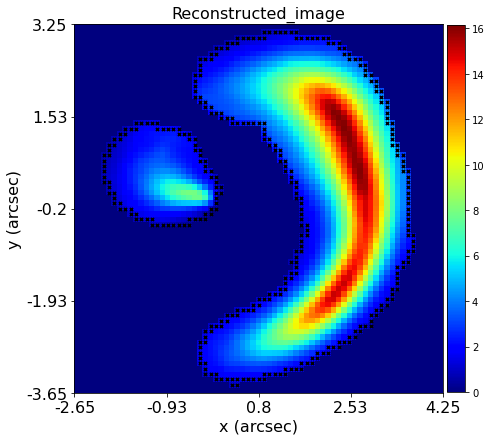

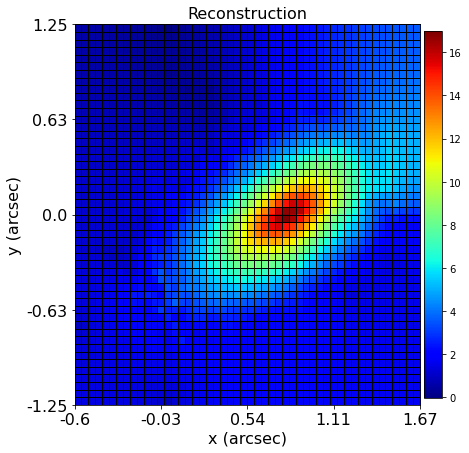

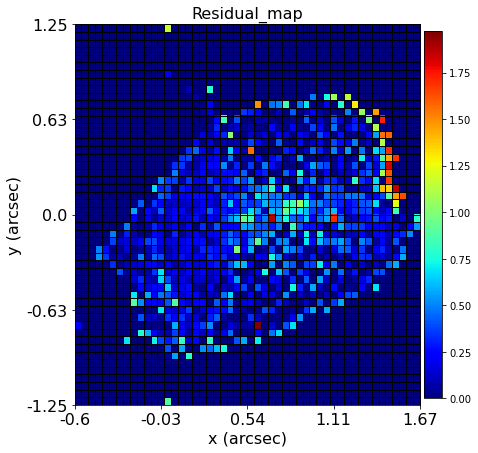

In [23]:
aplt.Inversion.reconstructed_image(inversion=inversion, include=aplt.Include(mask=True))

aplt.Inversion.reconstruction(
    inversion=inversion, include=aplt.Include(inversion_pixelization_grid=False, inversion_border=False)
)

aplt.Inversion.residual_map(inversion, include=aplt.Include(inversion_pixelization_grid=False,
                                                            inversion_border=False))

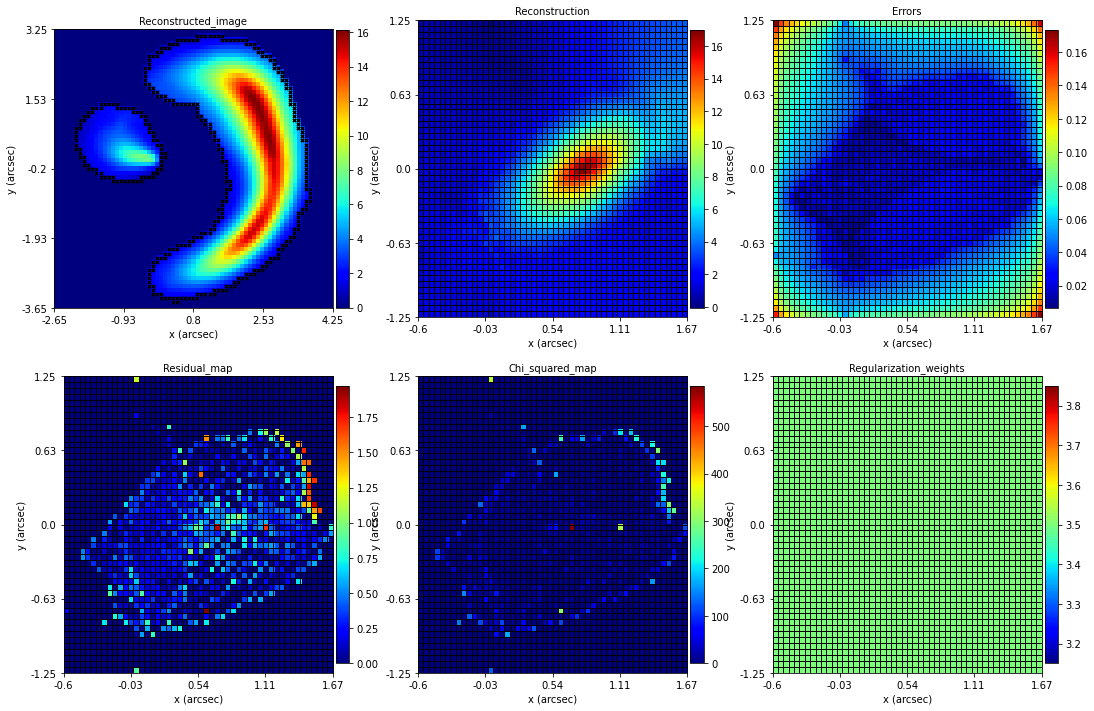

In [24]:
aplt.Inversion.subplot_inversion(inversion, include=aplt.Include(inversion_border=False,
                                                                 inversion_pixelization_grid=False,))

## Voronoi Inversion

In [26]:
voronoi = al.pix.VoronoiMagnification(shape=(40,40))

image_plane_sparse_grid = voronoi.sparse_grid_from_grid(grid=masked_imaging.grid)

source_galaxy_voronoi = al.Galaxy(
    redshift=z_source, pixelization=voronoi, regularization=al.reg.Constant(coefficient=3.5)
)

tracer_voronoi = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_voronoi])


Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model


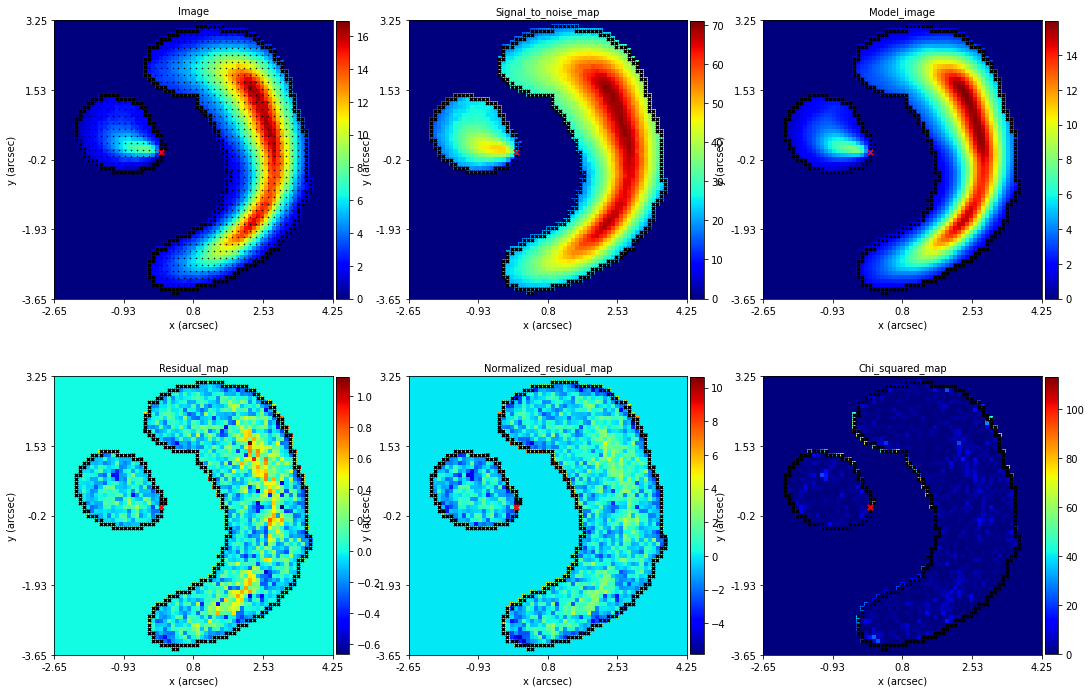

Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Critical curve could not be calculated due to an unphysical mass model
Caustics could not be calculated due to an unphysical mass model


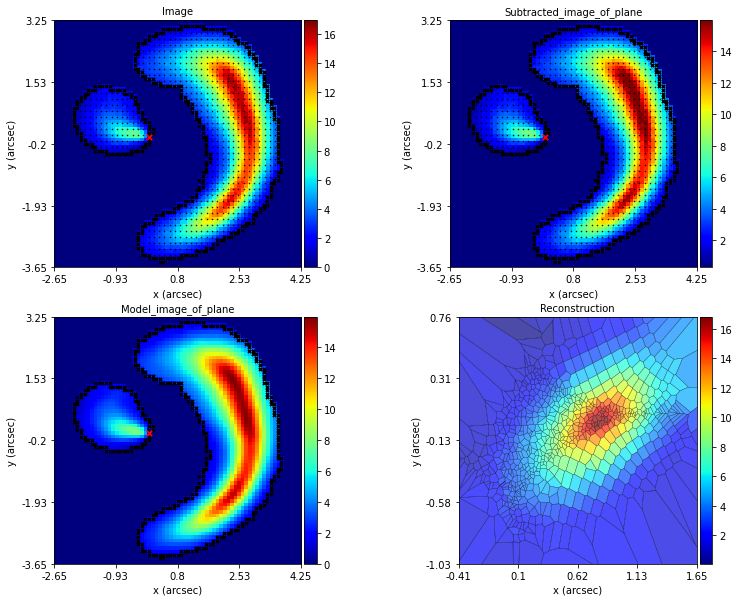

Computation time: 25.52130158499949


In [27]:
start = clock()

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer_voronoi)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit,
    include=aplt.Include(
        mask=True,
        inversion_image_pixelization_grid=True,
        inversion_pixelization_grid=True,
    ),
)
aplt.FitImaging.subplot_of_plane(
    fit=fit, plane_index=1, include=aplt.Include(mask=True, inversion_pixelization_grid=False,
                                                            inversion_border=False)
)
print("Computation time:", (clock() - start))